<a href="https://colab.research.google.com/github/crialejo24/YOPAL/blob/main/NDVIYOPAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
import rasterio

In [ ]:
from google.colab import drive
import ee
import geemap
import pandas as pd
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
# Drive
drive.mount('/content/drive')

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='cristian-ia')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def mask_s2_clouds(image):
  #https://philippgaertner.github.io/2020/08/percent-cloud-cover/
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  return image.updateMask(mask).divide(10000)



def look_opt(LON1, LAT1, LON2, LAT2, date1, date2, clouds):
  ROI = ee.Geometry.Rectangle(LON1, LAT1, LON2, LAT2)

  dataset_s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate(date1, date2)
              .filterBounds(ROI)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', clouds))
              .map(mask_s2_clouds))

  bandas = ['B4', 'B3', 'B2', 'B8'] #B4:Red, B3:Green, B2:Blue, B8:NIR #https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/
  visualization_s2 = {'min': 0,
                    'max': 0.3,
                    'bands': bandas[0:3]}
  imagen = dataset_s2.select(bandas).median().clip(ROI)
  imagen = imagen.visualize(**visualization_s2)

  imagen_median = dataset_s2.median().clip(ROI)
  ndvi = imagen_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
  ndvi = ndvi.visualize(min = -1, max = 1)

  return imagen, ndvi

In [ ]:
lat1, long1, lat2, long2 = 5.365804603562254, -72.41685796034183,  5.3116807463918505, -72.35932748826205
#years = ['2018']
years = ['2020', '2021', '2022', '2023', '2024']
dirname = '/content/drive/MyDrive/vision-ia/Teledetección con GEE/NDVI YOPAL'
subfolder = 'DownloadedNDVI_RGB'
subfolder_path = os.path.join(dirname, subfolder)
if not os.path.exists(subfolder_path):
  os.makedirs(subfolder_path)

ROI DE INTERES



In [ ]:
for year in years:
  print(year)
  date1 = year + '-01-01'
  date2 = year + '-12-31'
  img, ndvi = look_opt(long1, lat1, long2, lat2, date1, date2, 20)

  #Export RGB
  export_path = os.path.join(subfolder_path, year + '-RGB.tif')
  geemap.ee_export_image(img, export_path, scale = 10, file_per_band=False)

  #Export NDVI
  export_path = os.path.join(subfolder_path, year + '-NDVI.tif')
  geemap.ee_export_image(ndvi, export_path, scale = 10, file_per_band=False)


2020
Generating URL ...


Please wait ...


An error occurred while downloading.
Generating URL ...


Please wait ...
An error occurred while downloading.
2021
Generating URL ...


An error occurred while downloading.
Visibility check was unavailable. Please retry the request and contact support if the problem persists
Generating URL ...
Please wait ...


An error occurred while downloading.
2022
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Generating URL ...


Please wait ...


An error occurred while downloading.
2023
Generating URL ...


An error occurred while downloading.
Visibility check was unavailable. Please retry the request and contact support if the problem persists
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
2024
Generating URL ...
Please wait ...


An error occurred while downloading.
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.


In [ ]:
# LOOP DE PROCESAMIENTO
for year in years:
    print(f"Procesando {year}...")
    date1 = f"{year}-01-01"
    date2 = f"{year}-12-31"

    rgb_img, ndvi_real = look_opt(long1, lat1, long2, lat2, date1, date2, clouds=20)

    # Exportar imagen RGB visualizada
    rgb_path = os.path.join(subfolder_path, f"{year}-RGB.tif")
    geemap.ee_export_image(rgb_img, rgb_path, scale=10, file_per_band=False)

    # Exportar NDVI REAL (importante: file_per_band=True)
    ndvi_path = os.path.join(subfolder_path, f"{year}-NDVI-REAL.tif")
    geemap.ee_export_image(ndvi_real, ndvi_path, scale=10, file_per_band=True)

print("✅ Todos los años exportados correctamente.")


Procesando 2020...
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Generating URL ...


An error occurred while downloading.
Visibility check was unavailable. Please retry the request and contact support if the problem persists
Procesando 2021...
Generating URL ...


Please wait ...
An error occurred while downloading.
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Procesando 2022...
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Procesando 2023...
Generating URL ...


Please wait ...
An error occurred while downloading.
Generating URL ...


An error occurred while downloading.
Visibility check was unavailable. Please retry the request and contact support if the problem persists
Procesando 2024...
Generating URL ...


An error occurred while downloading.
Policy checks are unavailable.
Generating URL ...


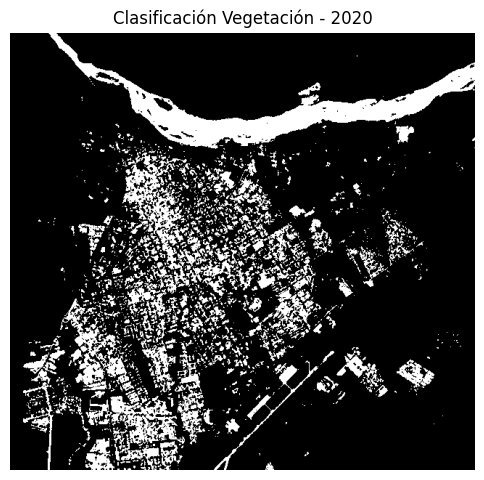

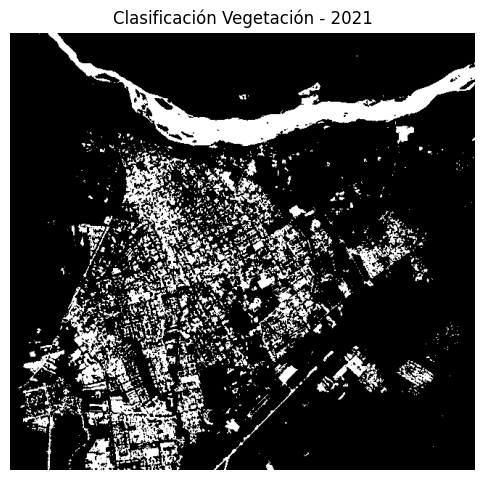

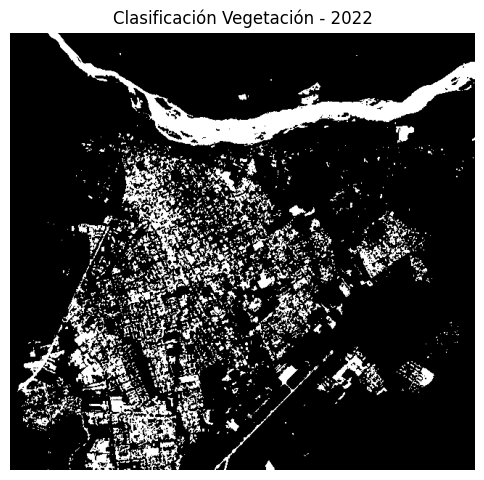

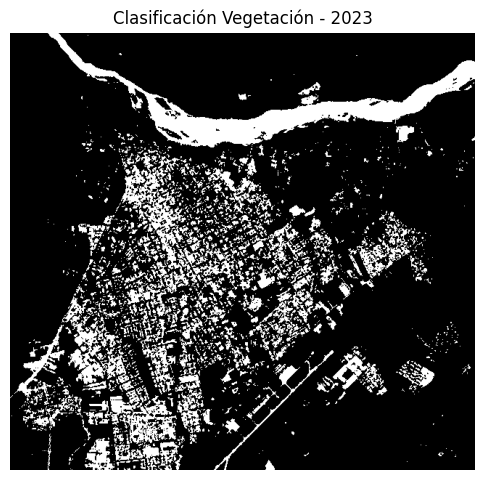

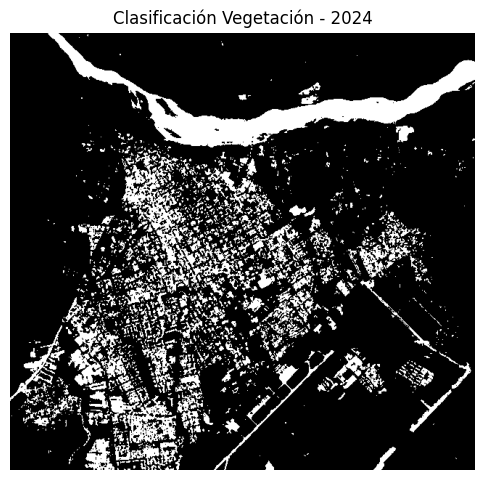

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

years = ['2020', '2021', '2022', '2023', '2024']
path = "/content/drive/MyDrive/vision-ia/Teledetección con GEE/NDVI YOPAL/DownloadedNDVI_RGB"
ndvi_stack = []
ndvi_bin_list = []

def binarizar_ndvi(ndvi, threshold=0.2):
    """1 = vegetación, 0 = no vegetación"""
    return (ndvi > threshold).astype(np.uint8)

for year in years:
    filepath = os.path.join(path, f"{year}-NDVI-REAL.NDVI.tif")
    with rasterio.open(filepath) as src:
        ndvi = src.read(1)
        ndvi_stack.append(ndvi)
        ndvi_bin = binarizar_ndvi(ndvi)
        ndvi_bin_list.append(ndvi_bin)

        plt.figure(figsize=(6, 6))
        plt.imshow(ndvi_bin, cmap='gray_r')
        plt.title(f'Clasificación Vegetación - {year}')
        plt.axis('off')
        plt.show()


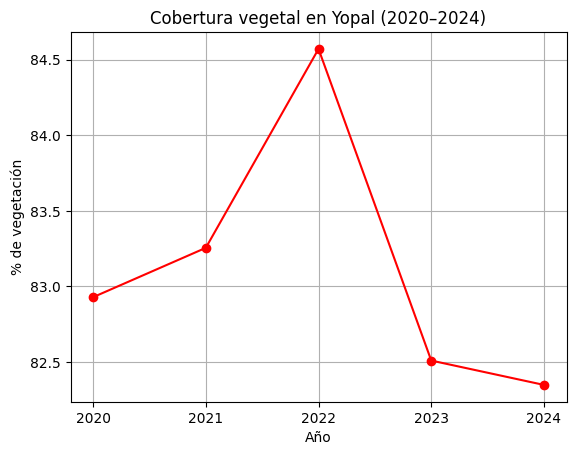

In [ ]:
area_vegetacion = []

for binary in ndvi_bin_list:
    vegetacion = np.sum(binary == 1)
    total = binary.size
    area_vegetacion.append(100 * vegetacion / total)

plt.figure()
plt.plot(years, area_vegetacion, marker='o', color='red')
plt.title('Cobertura vegetal en Yopal (2020–2024)')
plt.xlabel('Año')
plt.ylabel('% de vegetación')
plt.grid(True)
plt.show()


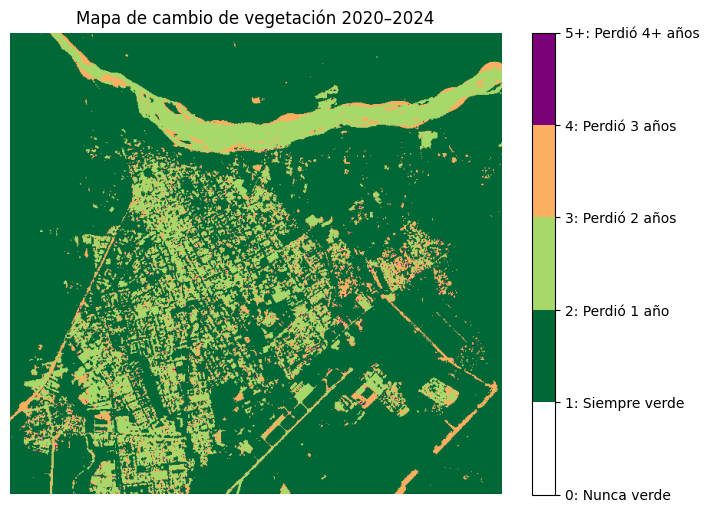

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Inicializar mapas
always_green = np.ones_like(ndvi_bin_list[0], dtype=bool)

# Calcular en qué años hubo vegetación (1) y cuándo se perdió
for binary in ndvi_bin_list:
    always_green &= (binary == 1)

loss_map = np.zeros_like(ndvi_bin_list[0], dtype=np.uint8)
for i in range(1, len(ndvi_bin_list)):
    loss = (ndvi_bin_list[i-1] == 1) & (ndvi_bin_list[i] == 0)
    loss_map += loss.astype(np.uint8)

# Mapa combinado:
# 0 = no vegetación nunca
# 1 = siempre vegetación (verde)
# 2+ = vegetación perdida (mapa de calor)

mapa_final = np.where(always_green, 1, loss_map + 2)  # 1 = siempre verde, >=2 = pérdida

# Crear un colormap personalizado
cmap = mcolors.ListedColormap([
   'white',       # 0 = nunca vegetación
    '#006837',     # 1 = siempre vegetación (verde oscuro)
    '#a6d96a',     # 2 = pérdida leve (verde claro)
    '#fdae61',     # 3 = pérdida moderada (naranja)
    '#d7191c',     # 4 = pérdida fuerte (rojo)
    '#7a0177'      # 5+ = pérdida extrema (púrpura)
])
bounds = [0, 1, 2, 3, 4, 5] # Adjusted bounds to match the number of labels
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 6))
plt.imshow(mapa_final, cmap=cmap, norm=norm)
plt.title('Mapa de cambio de vegetación 2020–2024')
cbar = plt.colorbar(ticks=bounds)
cbar.ax.set_yticklabels([
    '0: Nunca verde',
    '1: Siempre verde',
    '2: Perdió 1 año',
    '3: Perdió 2 años',
    '4: Perdió 3 años',
    '5+: Perdió 4+ años'
])
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(640.5), np.float64(602.5), np.float64(-0.5))

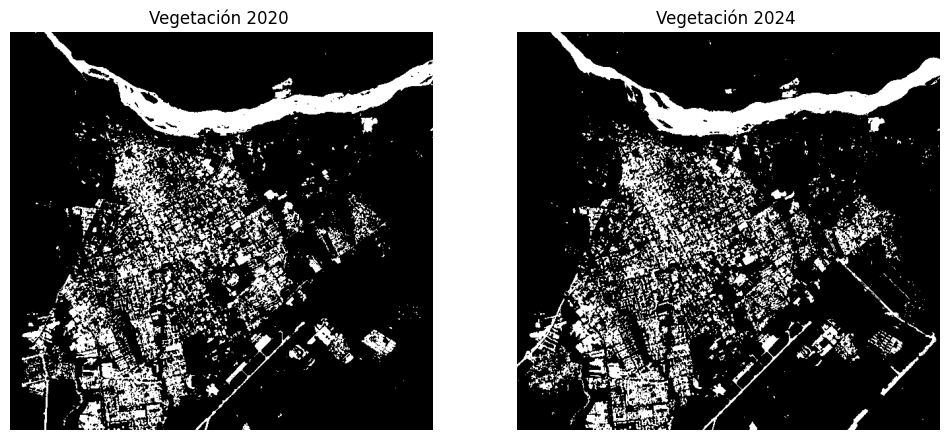

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargar imágenes
def load_ndvi(year, path):
    with rasterio.open(os.path.join(path, f"{year}-NDVI-REAL.NDVI.tif")) as src:
        return src.read(1)

ndvi_2020 = load_ndvi("2020", "/content/drive/MyDrive/vision-ia/Teledetección con GEE/NDVI YOPAL/DownloadedNDVI_RGB")
ndvi_2024 = load_ndvi("2024", "/content/drive/MyDrive/vision-ia/Teledetección con GEE/NDVI YOPAL/DownloadedNDVI_RGB")

# Binarizar (1 = vegetación, 0 = no vegetación)
threshold = 0.2  # Ajusta según tu criterio
bin_2020 = (ndvi_2020 > threshold).astype(int)
bin_2024 = (ndvi_2024 > threshold).astype(int)

# Comparación: 1 = siempre verde, 0 = nunca verde, 0.5 = cambio
comparison = np.zeros_like(bin_2020, dtype=float)
comparison[(bin_2020 == 1) & (bin_2024 == 1)] = 1    # Siempre vegetación (negro)
comparison[(bin_2020 == 0) & (bin_2024 == 0)] = 0    # Nunca vegetación (blanco)
comparison[((bin_2020 == 1) & (bin_2024 == 0)) |
           ((bin_2020 == 0) & (bin_2024 == 1))] = 0.5  # Cambio (gris)

# Visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(bin_2020, cmap='gray_r', vmin=0, vmax=1)
plt.title("Vegetación 2020 ")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bin_2024, cmap='gray_r', vmin=0, vmax=1)
plt.title("Vegetación 2024 ")
plt.axis('off')



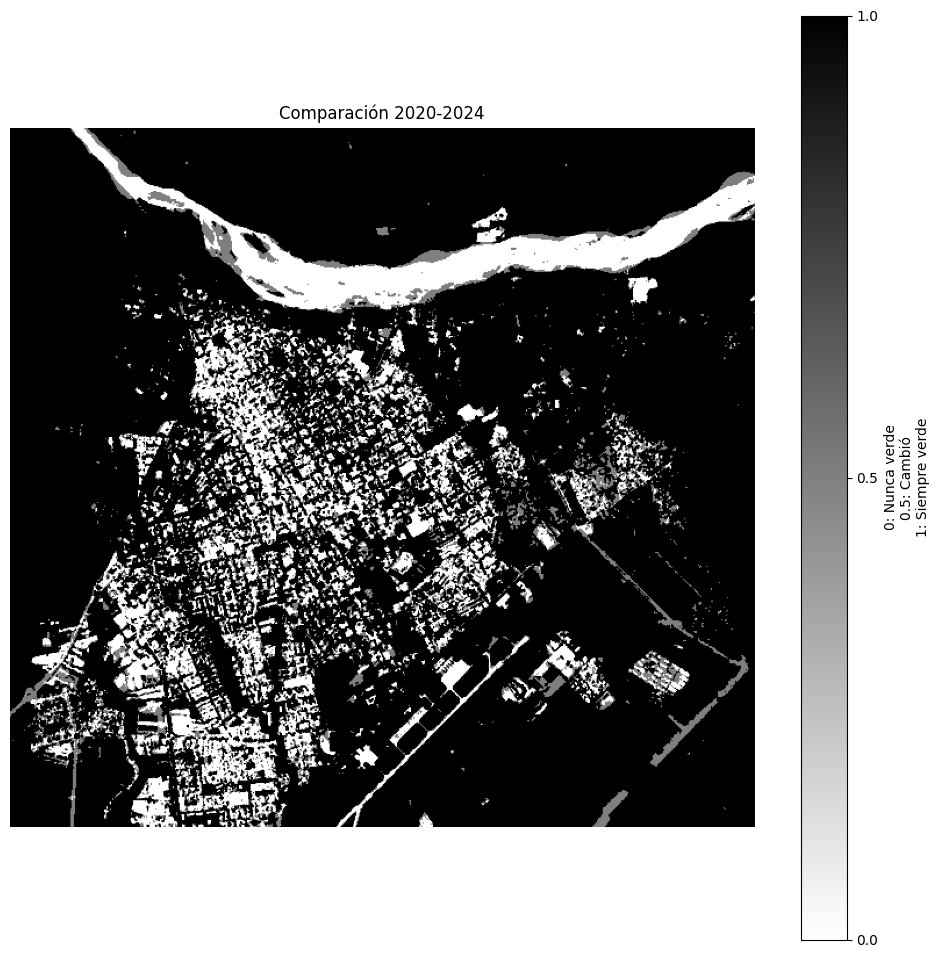

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(comparison, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 0.5, 1], label='0: Nunca verde\n0.5: Cambió\n1: Siempre verde')
plt.title("Comparación 2020-2024")
plt.axis('off')

plt.show()

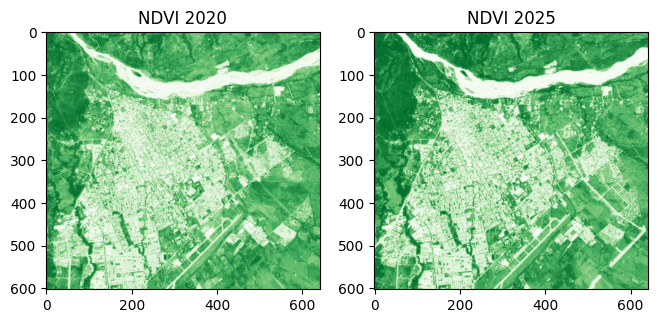

In [ ]:
# Calcular diferencia
diff = ndvi_2024 - ndvi_2020  # Positivo = ganancia, Negativo = pérdida

# Visualizar
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ndvi_2020, cmap='Greens', vmin=0, vmax=1)
plt.title('NDVI 2020')

plt.subplot(132)
plt.imshow(ndvi_2024, cmap='Greens', vmin=0, vmax=1)
plt.title('NDVI 2025')


plt.show()

Text(0.5, 1.0, 'Diferencia 2024 - 2020')

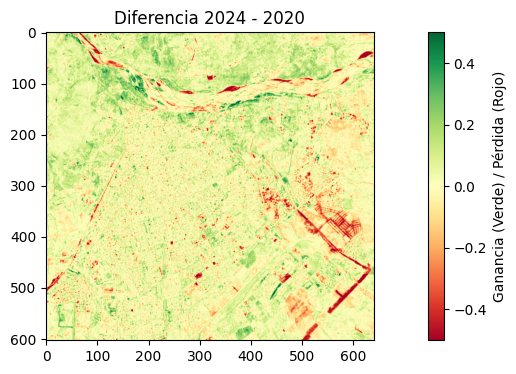

In [ ]:
plt.figure(figsize=(48, 4))
plt.subplot(133)
plt.imshow(diff, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Ganancia (Verde) / Pérdida (Rojo)')
plt.title('Diferencia 2024 - 2020')


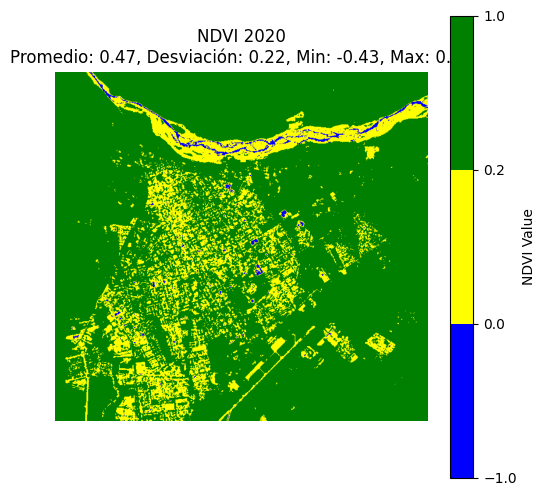

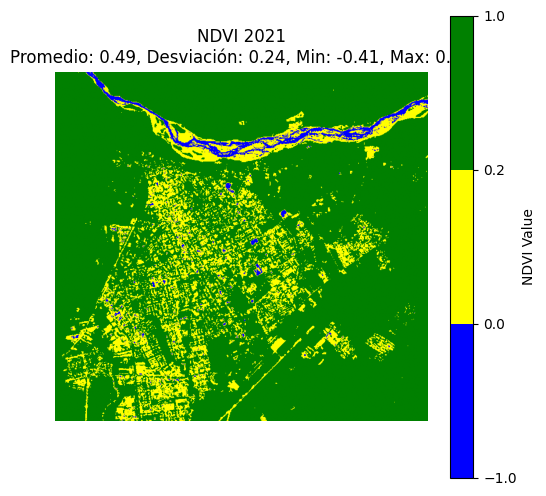

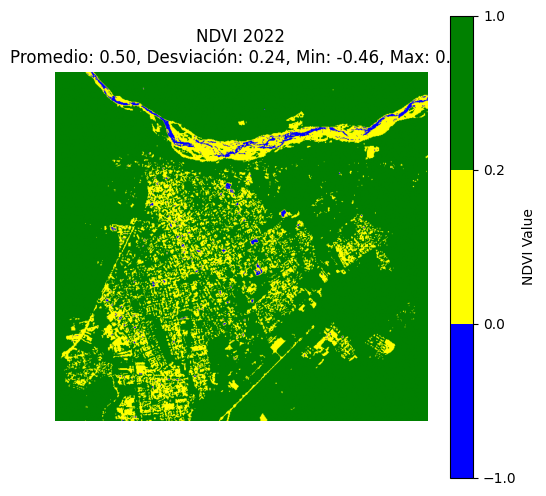

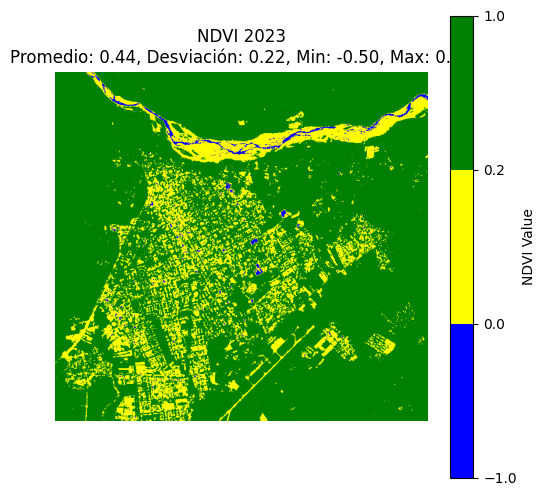

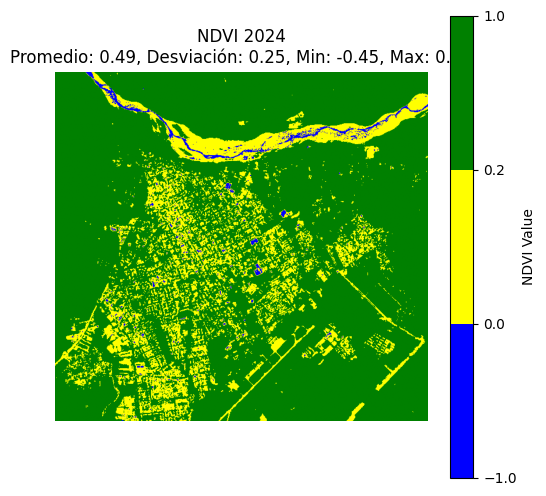

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Cargar imágenes NDVI
years = ['2020', '2021', '2022', '2023', '2024']
path = "/content/drive/MyDrive/vision-ia/Teledetección con GEE/NDVI YOPAL/DownloadedNDVI_RGB"

# Crear colormap personalizado
cmap = mcolors.ListedColormap(['blue', 'yellow', 'green'])
bounds = [-1, 0, 0.2, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for year in years:
    filepath = os.path.join(path, f"{year}-NDVI-REAL.NDVI.tif")
    with rasterio.open(filepath) as src:
        ndvi = src.read(1)

    # Calcular estadísticas
    mean_ndvi = np.mean(ndvi)
    std_ndvi = np.std(ndvi)
    min_ndvi = np.min(ndvi)
    max_ndvi = np.max(ndvi)

    # Mostrar imagen con mejor visualización
    plt.figure(figsize=(6, 6))
    plt.imshow(ndvi, cmap=cmap, norm=norm)
    plt.colorbar(label="NDVI Value")
    plt.title(f"NDVI {year}\nPromedio: {mean_ndvi:.2f}, Desviación: {std_ndvi:.2f}, Min: {min_ndvi:.2f}, Max: {max_ndvi:.2f}")
    plt.axis('off')
    plt.show()